Нужно написать приложение, которое будет получать на вход изображение.
В процессе определять, что перед камерой находится человек, задетектировав его лицо на кадре.
На изображении человек показывает жесты руками, а алгоритм должен считать их и классифицировать.

Подготовительный этап:
* на основе ResNet50 напишем сеть для предсказания жестов

Загрузка тренировочного датасета и библиотек

In [1]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d gti-upm/leapgestrecog

100% 2.13G/2.13G [01:17<00:00, 38.8MB/s]
100% 2.13G/2.13G [01:17<00:00, 29.5MB/s]


In [7]:
!unzip leapgestrecog.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0012.png  
  inflating: leapges

In [8]:
!pip install torchsummary

In [9]:
!pip install facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.1 MB/s eta 0:00:00


In [10]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 33.3 MB/s eta 0:00:00


In [11]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.transforms as tt
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import cv2
from PIL import Image

import mediapipe as mp
from pathlib import Path
from google.colab.patches import cv2_imshow

In [12]:
DATA_ROOT = Path('/content/leapgestrecog/leapGestRecog/')

Сохраним наименования классов

In [13]:
tmp_ds = ImageFolder(DATA_ROOT / '00')
CLASSES_NAME = tmp_ds.classes
CLASSES_NAME

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

Трансформация данных для трейна и теста

In [14]:
train_tfms = tt.Compose([
                         tt.Grayscale(num_output_channels=3), # серобелая шкала отображения изображений
                         tt.Resize([128, 128]),               # изменение размерности изображений
                         tt.RandomHorizontalFlip(),           # случайный горизонтальный флип
                         tt.RandomRotation(30),               # случайная ротация на 30 градусов
                         tt.ToTensor(),                       # перевод в тензор
                         ])

test_tfms = tt.Compose([
                        tt.Grayscale(num_output_channels=3),
                        tt.Resize([128, 128]),
                        tt.ToTensor(),
                        ])

Создание тренировочного и тестового датасета с различным препроцессингом

In [15]:
train_ds_list = []
test_ds_list = []
for dir in os.listdir(DATA_ROOT):
    train_ds = ImageFolder(os.path.join(DATA_ROOT, dir), train_tfms)
    test_ds = ImageFolder(os.path.join(DATA_ROOT, dir), test_tfms)
    train_ds_list.append(train_ds)
    test_ds_list.append(test_ds)

train_ds = ConcatDataset(train_ds_list)
test_ds = ConcatDataset(test_ds_list)

In [16]:
#общее количество изображений
LEN_DS = len(train_ds)
LEN_DS

20000

In [17]:
# перевод номера класса изображения в его наименование
def digit_to_classname(digit):
    for idx, itm in enumerate(CLASSES_NAME):
        if idx == digit:
            return itm

Оценка распределения классов в датасете

Counter({0: 2000, 1: 2000, 2: 2000, 3: 2000, 4: 2000, 5: 2000, 6: 2000, 7: 2000, 8: 2000, 9: 2000})


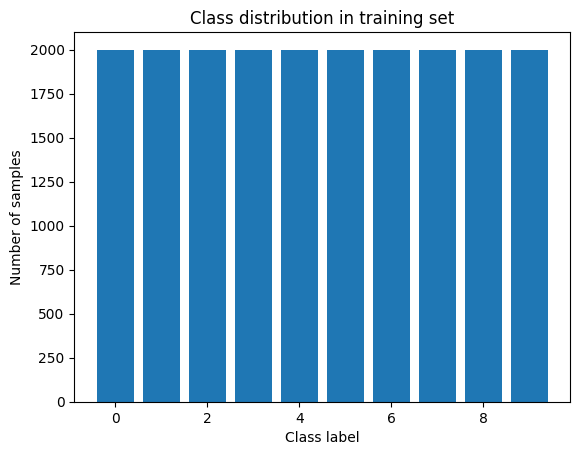

In [18]:
from collections import Counter

train_counts = Counter([label for _, label in train_ds])
print(train_counts)

import matplotlib.pyplot as plt
plt.bar(train_counts.keys(), train_counts.values())
plt.xlabel('Class label')
plt.ylabel('Number of samples')
plt.title('Class distribution in training set')
plt.show()

Датасет сбалансирован

Разбиение на трейновую и тестовую выборки

In [19]:
torch.manual_seed(1)

val_split = 0.2
split = int(LEN_DS * val_split)
indices = torch.randperm(LEN_DS)

train_ds = torch.utils.data.Subset(train_ds, indices[split:])
test_ds = torch.utils.data.Subset(test_ds, indices[:split])

len(train_ds), len(test_ds)

(16000, 4000)

In [20]:
#размерность рандомного тензора
train_ds[15000][0].size()

torch.Size([3, 128, 128])

Даталоадеры

In [80]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size, num_workers=1, shuffle=False)

Отобразим рандомное изображение из даталоадера

torch.Size([3, 128, 128])
tensor(2) 03_fist


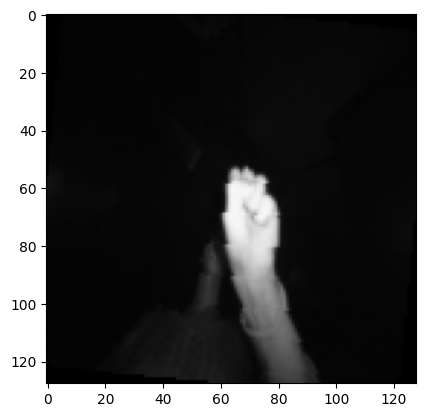

In [22]:
for img, l in train_dl:
    print(img[0].shape)
    print(l[0], digit_to_classname(l[0]))
    plt.imshow(img[0].permute(1, 2, 0)) #, cmap='gray')
    break

torch.Size([3, 128, 128])


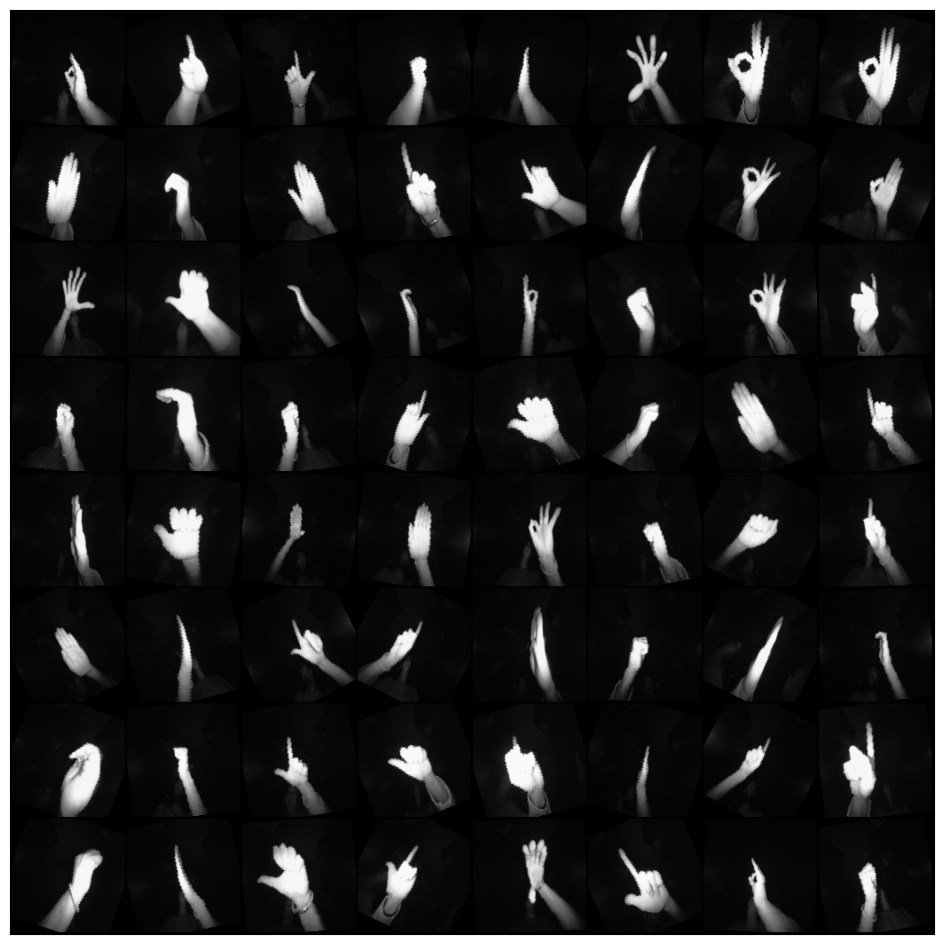

In [23]:
#Визуализация батча
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

show_batch(train_dl)

In [24]:
#определение активного устройства
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Импортирование предобученной модели resnet50




In [ ]:
resnet = models.resnet50(pretrained=True)
summary(resnet.to(device), input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
#блокировка обучаемости параметров модели
for param in resnet.parameters():
    param.requires_grad = False

Перепишем последний классификационный слой на 10 классов

In [ ]:
in_features = resnet.fc.in_features
fc = nn.Linear(in_features=in_features, out_features=len(CLASSES_NAME))
resnet.fc = fc

summary(resnet.to(device), input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

Определение тренируемых параметров и передача их оптимизатору

In [ ]:
params_to_update = []
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

Обучение модели

In [ ]:
from time import time

def train(model,
          criterion,
          optimizer,
          train_dataloader,
          test_dataloader,
          print_every,
          num_epoch):
    steps = 0
    train_losses, val_losses = [], []

    model.to(device)
    for epoch in range(num_epoch):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()

        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)

            # прямой прогон
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)

            # обратное распространение ошибки и шаг оптимизатора
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # логгирование
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
                correct_val, total_val = 0, 0
                with torch.no_grad():
                    model.eval()

                    val_loss = 0
                    for images, labels in test_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()

                        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)

                print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')
                print(f'Took {time() - iter_time:.3f} seconds')
                iter_time = time()

                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)


        print(f'Epoch took {time() - start_time:.3f}')
        torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}')

    return model, train_losses, val_losses

In [ ]:
print_every = 50
num_epoch = 10

resnet, train_losses, val_losses = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dl,
    test_dataloader=test_dl,
    print_every=print_every,
    num_epoch=num_epoch
)

Epoch [1]/[10]. Batch [50]/[250]. Train loss 1.416. Train acc 58.031. Val loss 1.393. Val acc 58.400. Took 31.935 seconds
Epoch [1]/[10]. Batch [100]/[250]. Train loss 1.171. Train acc 65.578. Val loss 0.937. Val acc 73.000. Took 31.071 seconds
Epoch [1]/[10]. Batch [150]/[250]. Train loss 0.991. Train acc 71.250. Val loss 0.737. Val acc 79.950. Took 30.660 seconds
Epoch [1]/[10]. Batch [200]/[250]. Train loss 0.870. Train acc 74.969. Val loss 0.671. Val acc 80.825. Took 31.271 seconds
Epoch [1]/[10]. Batch [250]/[250]. Train loss 0.783. Train acc 77.494. Val loss 0.592. Val acc 82.100. Took 30.431 seconds
Epoch took 155.454
Epoch [2]/[10]. Batch [50]/[250]. Train loss 0.103. Train acc 78.750. Val loss 0.758. Val acc 76.525. Took 32.834 seconds
Epoch [2]/[10]. Batch [100]/[250]. Train loss 0.153. Train acc 82.047. Val loss 0.640. Val acc 80.575. Took 30.911 seconds
Epoch [2]/[10]. Batch [150]/[250]. Train loss 0.184. Train acc 84.125. Val loss 0.575. Val acc 83.625. Took 30.266 seconds

In [ ]:
#сохранение модели
torch.save(resnet, '/content/drive/MyDrive/my_model')

In [68]:
#загрузка модели
resnet = torch.load('/content/drive/MyDrive/my_model')
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Проверка работы модели

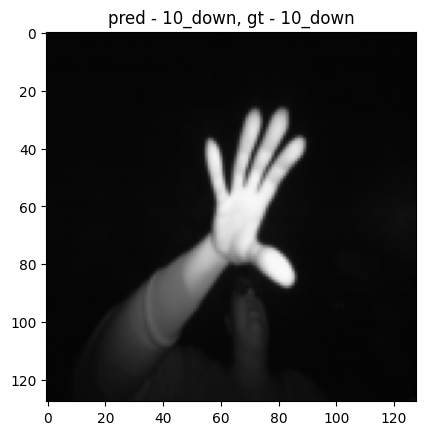

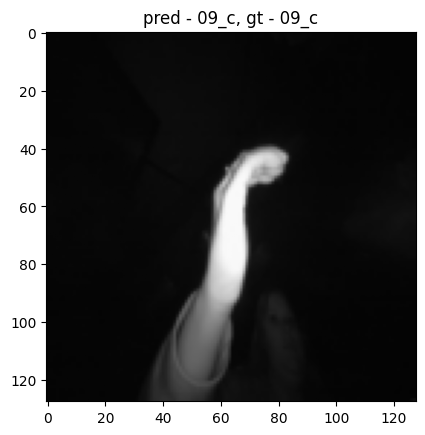

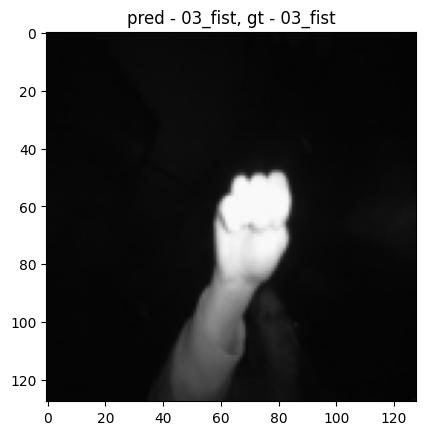

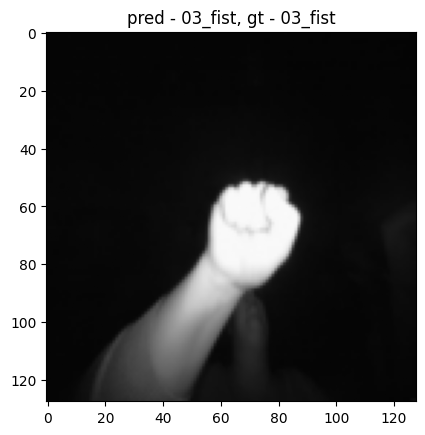

In [81]:
with torch.no_grad():
    for i, data in enumerate(test_dl, 3):
        images, labels = data[0].to(device), data[1].to(device)

        outputs = resnet(images)
        plt.title(f'pred - {digit_to_classname(outputs[0].argmax())}, gt - {digit_to_classname(labels[0])}')
        plt.imshow(images[0].cpu().permute(1, 2, 0), cmap='gray')
        plt.show()
        if i>5:
            break

In [82]:
images.shape

torch.Size([64, 3, 128, 128])

* Работа с новыми изображениями
* Детекция лица и руки

In [25]:
mp_face_detection = mp.solutions.face_detection
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

In [26]:
# инициализуем модели для трекинга лиц и жестов
face_detection = mp_face_detection.FaceDetection()
hand_tracking = mp_hands.Hands()

In [36]:
#бокс для руки
def get_bbox_coordinates(handLadmark, image_shape):
    """
    Get bounding box coordinates for a hand landmark.
    Args:
        handLadmark: A HandLandmark object.
        image_shape: A tuple of the form (height, width).
    Returns:
        A tuple of the form (xmin, ymin, xmax, ymax).
    """
    all_x, all_y = [], [] # store all x and y points in list
    for hnd in mp_hands.HandLandmark:
        all_x.append(int(handLadmark.landmark[hnd].x * image_shape[1])) # multiply x by image width
        all_y.append(int(handLadmark.landmark[hnd].y * image_shape[0])) # multiply y by image height

    return min(all_x), min(all_y), max(all_x), max(all_y) # return as (xmin, ymin, xmax, ymax)

In [45]:
!mkdir /content/example

In [46]:
filename = '/content/example/men1.jpg'

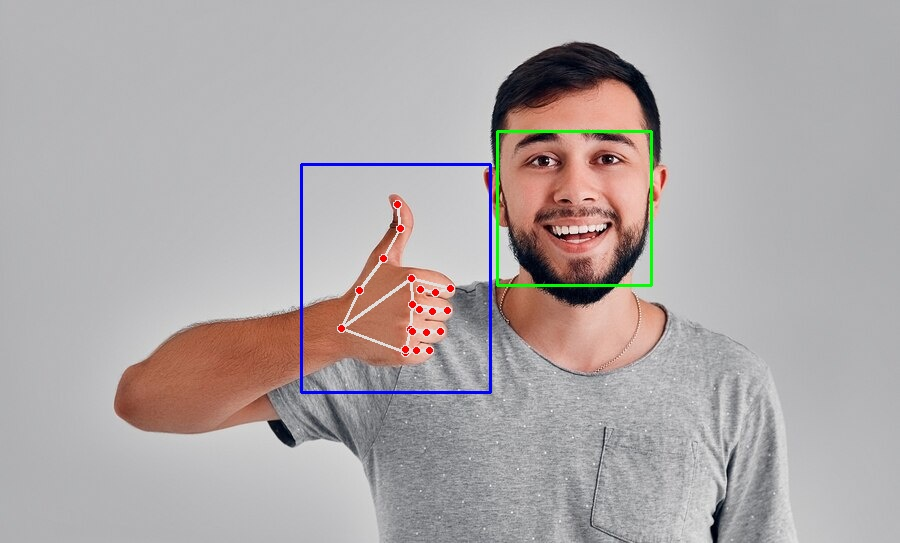

Это человек


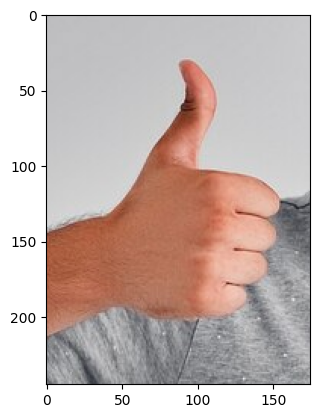

In [92]:
# считываем
image_path = os.path.join(filename)
image = cv2.imread(image_path)

# преобразуем изображение в ргб
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# поиск лица
face_results = face_detection.process(image_rgb)
if face_results.detections:
    for detection in face_results.detections:
        # извлекаем координаты границ
        bbox = detection.location_data.relative_bounding_box
        h, w, c = image.shape
        x, y, width, height = int(bbox.xmin * w), int(bbox.ymin * h), int(bbox.width * w), int(bbox.height * h)

        # поиск лица
        cv2.rectangle(image, (x, y), (x + width, y + height), (0, 255, 0), 2)

# поиск рук
hand_results = hand_tracking.process(image_rgb)
if hand_results.multi_hand_landmarks:
    for hand_landmarks in hand_results.multi_hand_landmarks:
        # отрисовка найденного
        mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
        x, y, width, height = get_bbox_coordinates(hand_landmarks, image.shape)
        x, y, width, height = x-40, y-40, width+40, height+40
        cv2.rectangle(image, (x, y), (width, height), (255, 0, 0), 2)

        cropped_image = image_rgb[y:y+height//2+height//8, x:x+width//2-width//7]
        plt.imshow(cropped_image)
        cv2.imwrite('contour1.png', cropped_image)


# отображение результата
cv2.imwrite('result.jpg', image)
img = cv2.imread('result.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

if face_results.detections:
  print('Это человек')
else:
  print('Это не человек')



Препроцессинг нового изображения

In [72]:
cropped_image = Image.fromarray(np.uint8(cropped_image)).convert('RGB')

In [73]:
cropped_image = test_tfms(cropped_image)

torch.Size([3, 128, 128])


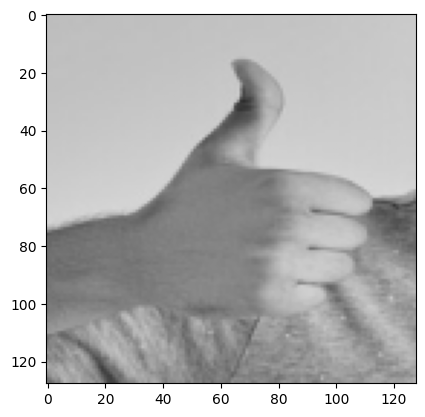

In [75]:
print(cropped_image.shape)
plt.imshow(cropped_image.permute(1, 2, 0)) #, cmap='gray')

Предсказание на новом изображении

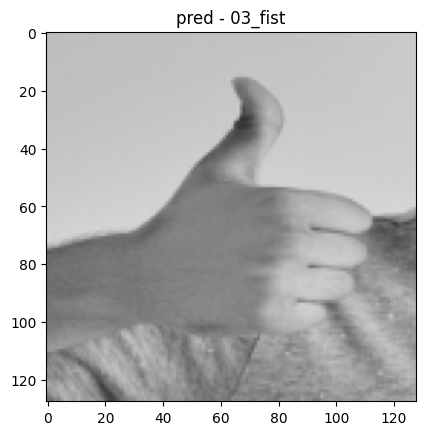

In [91]:
with torch.no_grad():
    image = cropped_image.view(1, 3, 128, 128) # перевод в 4D
    image = image.to(device)
    outputs = resnet(image)
    plt.title(f'pred - {digit_to_classname(outputs[0].argmax())}')
    plt.imshow(image[0].cpu().permute(1, 2, 0), cmap='gray')
    plt.show()